In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `TransparenceMix` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom, HoleMakerBounded, HoleMakerAttention
from semantic_segmentation_augmentations.holesfilling import TransparenceMix

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "TransparenceMix"
}

In order to know how does this technique work, we can show an example.

This technique share the key idea with `CutOutRandom`, but the region is overlapped using transparence. Thus is, given the regions $A$ and $B$ of shape $S$ and their respective masks $A'$ and $B'$, the new region $C$ and its mask $C'$ are computed as follows:

$$
f(A, A', B, B') = 
\begin{cases}
    (a_{ijz}, a'_{ij})  & \mbox{if } \ a'_{ij} \ne 0 \\
    (b_{ijz}, b'_{ij})  & \mbox{if } \ a'_{ij} = 0 \\
\end{cases} \ \ \
,\ 0 \le i, j, z \lt S_i, S_j, S_z
$$

Where $a'_{ij}$ is the $ij$ component of the matrix $A'$. $C$ and $C'$ will have $S$ as shape too.

We should note that, if the regions $A$ and $B$ covers all the image where they have been extracted, then $C$ is the full-information mix of $A$ and $B$.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


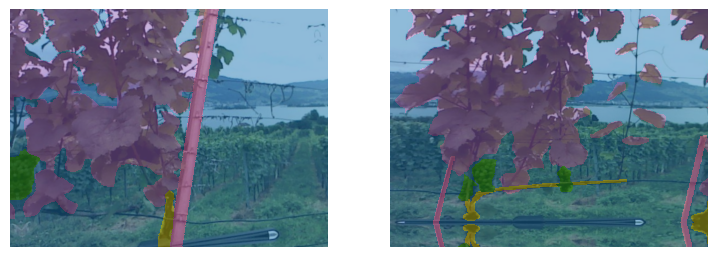

In [ ]:
cv = TransparenceMix(holes_num = 1, p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cv) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cv.x, cv.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for size in [(150, 150), (250, 250), (350, 350)]:
    for holemaker in [HoleMakerRandom, HoleMakerBounded, HoleMakerAttention]:
        tm = TransparenceMix(hole_maker = holemaker(hole_size = size))
        learner_hparams["cbs"] = [esc, tm]
        r = evaluate(db_hparams,
                     dls_hparams,
                     technique,
                     learner_hparams,
                     learning_hparams,
                     learning_mode,
                     saving_hparams,
                     verbose = True
                    )
        results.update({
            str(size) + str(holemaker).split("'")[1].split(".")[2]: r["DiceMulti"]
        })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.926230,0.590248,0.331178,00:21
1,0.704108,0.732565,0.260432,00:19
2,0.923319,0.750283,0.264205,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.555846,0.478786,0.357148,00:20
1,0.470196,0.385563,0.435125,00:19
2,0.414980,0.341260,0.514087,00:19
3,0.393516,0.376861,0.542225,00:20
4,0.366289,0.321900,0.736071,00:19
5,0.346312,0.307096,0.765475,00:19
6,0.318548,0.307215,0.758479,00:19
7,0.306257,0.335033,0.774586,00:20
8,0.303092,0.280218,0.795499,00:20
9,0.287431,0.277164,0.793610,00:19


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.17460282146930695  /  DiceMulti: 0.8714651705712735  
Saving best model because DiceMulti 0.8715 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.212363,0.915355,0.288158,00:19
1,0.780864,0.437812,0.427354,00:20
2,0.624512,1.963611,0.205402,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.546142,0.415272,0.549273,00:20
1,0.432336,0.305605,0.688873,00:20
2,0.383073,0.292860,0.746247,00:20
3,0.344470,0.272666,0.771118,00:20
4,0.330532,0.290311,0.797702,00:20
5,0.316226,0.285051,0.790310,00:20
6,0.302385,0.278448,0.795860,00:20
7,0.299935,0.286341,0.809146,00:20
8,0.302172,0.298299,0.768470,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.27406278252601624  /  DiceMulti: 0.7795669669119165  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.903205,0.582049,0.347669,00:20
1,0.673059,0.472376,0.349672,00:20
2,0.581922,0.366927,0.561529,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.365744,0.340785,0.657075,00:20
1,0.344963,0.325773,0.694018,00:20
2,0.323219,0.374353,0.723536,00:20
3,0.307421,0.272100,0.778378,00:20
4,0.322392,0.400571,0.751561,00:20
5,0.312874,0.311819,0.757299,00:20
6,0.303639,0.307037,0.750544,00:20
7,0.293935,0.275531,0.781621,00:20
8,0.290100,0.436388,0.740960,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.330231249332428  /  DiceMulti: 0.7918174688732375  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.936881,0.801939,0.308056,00:20
1,0.719821,0.371244,0.379257,00:20
2,0.598178,0.359275,0.362874,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.394940,0.320493,0.664622,00:20
1,0.362125,0.264979,0.782636,00:20
2,0.346029,0.257792,0.712389,00:20
3,0.326746,0.239654,0.786173,00:20
4,0.329943,0.236393,0.811573,00:20
5,0.322704,0.263847,0.815393,00:20
6,0.326369,0.243660,0.797434,00:20
7,0.323330,0.265495,0.737687,00:20
8,0.311826,0.246570,0.700336,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.2532135248184204  /  DiceMulti: 0.7264224998423245  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.127487,0.715160,0.310380,00:20
1,0.757038,0.585073,0.347302,00:20
2,0.618506,0.435362,0.379388,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.396844,0.347849,0.618819,00:20
1,0.359514,0.310079,0.709649,00:20
2,0.344422,0.287496,0.739047,00:20
3,0.329685,0.288602,0.751040,00:20
4,0.315497,0.289940,0.760169,00:20
5,0.311409,0.255110,0.817631,00:20
6,0.300983,0.300347,0.782684,00:20
7,0.290242,0.257733,0.814000,00:20
8,0.281952,0.278320,0.780997,00:20
9,0.288641,0.276976,0.768848,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.27841100096702576  /  DiceMulti: 0.6903844399594962  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.942114,0.662952,0.318035,00:20
1,0.626549,0.666356,0.396063,00:20
2,0.541804,0.537775,0.472868,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.353454,0.432059,0.576927,00:20
1,0.318330,0.386332,0.662242,00:20
2,0.304118,0.473265,0.666235,00:20
3,0.300546,0.425570,0.680173,00:20
4,0.292984,0.505695,0.641291,00:20
5,0.280499,0.430649,0.717398,00:20
6,0.280530,0.412161,0.683338,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.2531909942626953  /  DiceMulti: 0.7981246832247786  
Saving best model because DiceMulti 0.7981 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.018150,0.729082,0.309548,00:19
1,0.753631,0.484329,0.356067,00:20
2,0.630950,0.476348,0.351497,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.402286,0.427491,0.582611,00:20
1,0.377050,0.350548,0.701149,00:20
2,0.352658,0.318996,0.710845,00:20
3,0.335354,0.382710,0.647086,00:20
4,0.324085,0.321809,0.729398,00:20
5,0.325626,0.307729,0.797336,00:20
6,0.316315,0.299642,0.768115,00:20
7,0.306355,0.254354,0.804115,00:20
8,0.293975,0.286923,0.791952,00:20
9,0.281296,0.253741,0.804472,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.17947174608707428  /  DiceMulti: 0.8655080910076002  
Saving best model because DiceMulti 0.8655 >= 0.7981.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.837091,0.453589,0.351135,00:20
1,0.595475,0.473647,0.354170,00:20
2,0.757249,1.023237,0.214091,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.583930,0.435192,0.366651,00:21
1,0.496528,0.367561,0.622787,00:20
2,0.448241,0.394590,0.550498,00:20
3,0.388276,0.303522,0.743206,00:20
4,0.352568,0.360886,0.740670,00:20
5,0.328326,0.290165,0.708349,00:20
6,0.315282,0.292887,0.767550,00:20
7,0.323010,0.356401,0.716133,00:20
8,0.305783,0.337873,0.780035,00:20
9,0.291066,0.296836,0.804577,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.17973226308822632  /  DiceMulti: 0.8395774256898194  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.939463,0.644941,0.323533,00:20
1,0.660341,0.409648,0.392590,00:20
2,4.713172,1.110473,0.197652,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.684747,0.469142,0.350584,00:20
1,0.544409,0.342152,0.376268,00:20
2,0.484355,0.312458,0.451644,00:20
3,0.432638,0.313196,0.658534,00:20
4,0.409180,0.271367,0.630555,00:20
5,0.385588,0.289231,0.628484,00:20
6,0.364147,0.256097,0.765447,00:20
7,0.342106,0.246006,0.756930,00:20
8,0.320191,0.250945,0.814520,00:20
9,0.336740,0.243667,0.787599,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.19906263053417206  /  DiceMulti: 0.8648818835920252  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.900843,0.556319,0.346255,00:20
1,0.662421,0.511962,0.380129,00:20
2,1.082692,1.111289,0.254072,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.627031,0.502818,0.346957,00:20
1,0.493544,0.369897,0.553848,00:20
2,0.430785,0.350010,0.580354,00:20
3,0.388949,0.345619,0.588266,00:20
4,0.365289,0.300629,0.728054,00:20
5,0.366693,0.327844,0.709404,00:20
6,0.348964,0.381045,0.749915,00:20
7,0.326588,0.274269,0.757750,00:20
8,0.313406,0.275331,0.779937,00:20
9,0.305563,0.294655,0.800670,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.21635104715824127  /  DiceMulti: 0.7981356943076069  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.798516,0.532290,0.338615,00:20
1,0.643849,0.536030,0.334243,00:20
2,0.598086,0.580558,0.347920,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.379223,0.506026,0.586316,00:20
1,0.346819,0.461630,0.624650,00:20
2,0.323533,0.416845,0.655767,00:20
3,0.309588,0.442442,0.672745,00:20
4,0.295063,0.466273,0.681497,00:20
5,0.281127,0.443483,0.646952,00:20
6,0.272175,0.391395,0.721766,00:20
7,0.277224,0.446345,0.678271,00:20
8,0.263523,0.385139,0.734690,00:20
9,0.246953,0.428280,0.739424,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.20112177729606628  /  DiceMulti: 0.852381669187599  
Saving best model because DiceMulti 0.8524 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.935226,0.577131,0.338176,00:20
1,0.718740,0.546806,0.337534,00:20
2,1.208724,1.124354,0.130911,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.620565,0.457200,0.360742,00:20
1,0.527196,0.433984,0.382080,00:20
2,0.466711,0.366604,0.428135,00:20
3,0.410341,0.325609,0.659257,00:20
4,0.374379,0.446984,0.640341,00:20
5,0.363483,0.330316,0.762234,00:20
6,0.340776,0.304116,0.716934,00:20
7,0.337513,0.283478,0.774861,00:20
8,0.312446,0.367297,0.726954,00:20
9,0.299368,0.345459,0.790828,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.20586156845092773  /  DiceMulti: 0.827389756372631  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.065325,0.710814,0.326507,00:20
1,0.721161,0.659692,0.292697,00:20
2,0.656866,0.561389,0.343822,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.434624,0.363090,0.524911,00:20
1,0.388634,0.321108,0.611608,00:20
2,0.366001,0.463403,0.625294,00:21
3,0.368480,0.341279,0.672174,00:21
4,0.343529,0.290734,0.757682,00:20
5,0.321911,0.305603,0.746774,00:20
6,0.302269,0.287176,0.778381,00:20
7,0.298252,0.294784,0.734126,00:20
8,0.297851,0.323314,0.767482,00:20
9,0.288563,0.282397,0.801985,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.21764585375785828  /  DiceMulti: 0.839486128332895  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.149414,0.974873,0.199200,00:20
1,0.831162,0.434930,0.356274,00:20
2,0.718604,0.432560,0.351655,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.452971,0.327268,0.436468,00:20
1,0.417843,0.296619,0.623513,00:20
2,0.376623,0.275978,0.734944,00:20
3,0.361007,0.276895,0.751179,00:20
4,0.348206,0.253556,0.784020,00:20
5,0.333732,0.257768,0.751755,00:20
6,0.324679,0.239185,0.783519,00:20
7,0.318321,0.280493,0.802584,00:20
8,0.305648,0.224217,0.793647,00:20
9,0.288966,0.226742,0.807139,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.20676091313362122  /  DiceMulti: 0.862107867963551  
Saving best model because DiceMulti 0.8621 >= 0.8524.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.739753,0.571541,0.349059,00:20
1,0.619824,0.500823,0.358732,00:20
2,5.892603,4.571033,0.133351,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,1.167243,0.481749,0.352309,00:20
1,0.677522,0.410813,0.417888,00:20
2,0.537859,0.373698,0.453510,00:20
3,0.450422,0.322244,0.718492,00:20
4,0.386096,0.284982,0.760142,00:20
5,0.363668,0.352969,0.693200,00:20
6,0.339287,0.273881,0.767998,00:20
7,0.316965,0.369422,0.697700,00:20
8,0.312330,0.297967,0.774891,00:20
9,0.302567,0.260101,0.801452,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.2357012927532196  /  DiceMulti: 0.814476134597253  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.940574,0.766263,0.312102,00:20
1,0.652831,0.454836,0.401785,00:20
2,0.499797,0.586745,0.470026,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.315258,0.442225,0.650228,00:21
1,0.296260,0.413993,0.691736,00:21
2,0.289232,0.525572,0.685133,00:20
3,0.270092,0.410042,0.696993,00:20
4,0.260882,0.413837,0.719828,00:20
5,0.266217,0.439591,0.659005,00:20
6,0.332362,0.462699,0.682942,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.260332316160202  /  DiceMulti: 0.7999086044111821  
Saving best model because DiceMulti 0.7999 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.897431,0.667394,0.334968,00:20
1,0.664340,0.485191,0.405629,00:20
2,0.685605,0.886434,0.218159,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.529792,0.407835,0.530485,00:20
1,0.449038,0.358832,0.568579,00:20
2,0.399915,0.333232,0.608734,00:21
3,0.373929,0.310744,0.738062,00:20
4,0.371813,0.409960,0.585827,00:20
5,0.365305,0.315651,0.669415,00:20
6,0.343331,0.277552,0.772046,00:21
7,0.327843,0.279576,0.734831,00:20
8,0.314363,0.272154,0.795831,00:20
9,0.293006,0.265826,0.786468,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.17195451259613037  /  DiceMulti: 0.8691441273168652  
Saving best model because DiceMulti 0.8691 >= 0.7999.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.935521,0.490411,0.348080,00:20
1,0.705307,0.490107,0.348303,00:20
2,3.900768,0.925363,0.264132,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.626433,0.589988,0.339890,00:21
1,0.512383,0.361219,0.439948,00:21
2,0.427043,0.327495,0.560695,00:20
3,0.387494,0.316202,0.735226,00:20
4,0.352602,0.292168,0.737081,00:20
5,0.323278,0.367289,0.726535,00:20
6,0.316734,0.300197,0.747506,00:20
7,0.320256,0.296092,0.778603,00:20
8,0.308226,0.316545,0.777323,00:20
9,0.291584,0.283201,0.787884,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2206629067659378  /  DiceMulti: 0.8193574084224068  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.095875,0.932021,0.281106,00:20
1,0.733273,0.401271,0.436757,00:20
2,1.579108,1.111591,0.138922,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.704265,0.411068,0.357964,00:20
1,0.560140,0.358579,0.360493,00:21
2,0.498742,0.368854,0.436238,00:21
3,0.441086,0.272674,0.666924,00:20
4,0.393169,0.279292,0.771016,00:21
5,0.369708,0.246740,0.724886,00:20
6,0.342290,0.226505,0.806219,00:20
7,0.331147,0.237076,0.790059,00:20
8,0.346639,0.240870,0.808268,00:20
9,0.326759,0.221871,0.805712,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.22043997049331665  /  DiceMulti: 0.8530872824686513  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.915602,0.620452,0.338502,00:20
1,0.699609,0.866234,0.319388,00:20
2,1.116669,0.800578,0.297304,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.508301,0.465339,0.378217,00:20
1,0.460868,0.401962,0.409921,00:21
2,0.423747,0.410464,0.569686,00:20
3,0.386412,0.306649,0.732111,00:21
4,0.361176,0.352662,0.692753,00:21
5,0.338192,0.283876,0.770563,00:20
6,0.319766,0.296185,0.777440,00:21
7,0.310948,0.288322,0.783621,00:21
8,0.294599,0.257965,0.791261,00:21
9,0.291763,0.323840,0.771125,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.2305644005537033  /  DiceMulti: 0.825076422473338  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.807543,0.613298,0.319986,00:20
1,0.608526,0.550220,0.367354,00:20
2,0.558427,0.523421,0.381035,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.385504,0.535566,0.552846,00:21
1,0.350376,0.466722,0.631659,00:21
2,0.318279,0.423513,0.682622,00:21
3,0.298004,0.465441,0.621120,00:21
4,0.292539,0.432469,0.700932,00:20
5,0.284323,0.489498,0.709354,00:21
6,0.274890,0.387183,0.709094,00:21
7,0.280404,0.421402,0.697143,00:21
8,0.281535,0.440987,0.705339,00:20
9,0.260431,0.424035,0.711183,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2139502763748169  /  DiceMulti: 0.8407044480356897  
Saving best model because DiceMulti 0.8407 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.856167,0.502828,0.348940,00:20
1,0.641223,0.430416,0.406085,00:20
2,1.046117,0.888004,0.289015,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.541256,0.426662,0.381573,00:20
1,0.469881,0.398622,0.426257,00:20
2,0.437257,0.374561,0.543677,00:20
3,0.405386,0.316248,0.719521,00:20
4,0.371968,0.297491,0.762196,00:20
5,0.356882,0.294410,0.695915,00:20
6,0.340043,0.270356,0.784110,00:20
7,0.323807,0.292320,0.749439,00:20
8,0.317778,0.262472,0.785994,00:20
9,0.301807,0.263903,0.802118,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.17972691357135773  /  DiceMulti: 0.8665379146001395  
Saving best model because DiceMulti 0.8665 >= 0.8407.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.969485,0.593935,0.331960,00:20
1,0.694130,0.590006,0.369753,00:20
2,0.580093,0.426525,0.360727,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.386886,0.318469,0.684454,00:20
1,0.361412,0.307068,0.735046,00:20
2,0.340597,0.305540,0.757797,00:20
3,0.323026,0.287355,0.728293,00:20
4,0.314108,0.289588,0.786745,00:20
5,0.311479,0.286193,0.786264,00:20
6,0.306667,0.286230,0.799479,00:20
7,0.303131,0.373034,0.702121,00:20
8,0.296421,0.298155,0.767528,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.22687047719955444  /  DiceMulti: 0.8086739555684777  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.018670,0.601297,0.331219,00:20
1,0.767812,0.858853,0.177742,00:20
2,0.686274,0.461072,0.441726,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.433748,0.318345,0.472653,00:20
1,0.395549,0.270810,0.733374,00:20
2,0.369503,0.250388,0.763335,00:20
3,0.354408,0.259491,0.715044,00:20
4,0.336206,0.247831,0.801410,00:20
5,0.332939,0.241047,0.791799,00:20
6,0.325062,0.239901,0.817915,00:20
7,0.309866,0.244620,0.785331,00:20
8,0.302606,0.215812,0.820765,00:20
9,0.291090,0.231209,0.796649,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.23207610845565796  /  DiceMulti: 0.816085149538079  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.902935,0.582741,0.341877,00:20
1,0.629315,0.660340,0.376188,00:20
2,0.578165,0.413066,0.470204,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.395866,0.343571,0.548013,00:20
1,0.382821,0.335883,0.582621,00:20
2,0.354764,0.300132,0.760418,00:20
3,0.337298,0.296363,0.748976,00:20
4,0.322367,0.259751,0.796251,00:20
5,0.320018,0.284817,0.777992,00:20
6,0.315068,0.281050,0.769120,00:20
7,0.300459,0.255537,0.814158,00:20
8,0.286832,0.276173,0.745826,00:20
9,0.277883,0.261918,0.823094,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.29794445633888245  /  DiceMulti: 0.7891191676695575  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.892774,0.585242,0.329492,00:20
1,0.667522,0.484055,0.376719,00:20
2,0.559680,0.502346,0.491907,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.376742,0.501200,0.602315,00:20
1,0.338563,0.415193,0.650545,00:20
2,0.307724,0.405435,0.703681,00:20
3,0.297968,0.411172,0.688063,00:20
4,0.284867,0.396193,0.716785,00:20
5,0.277424,0.368702,0.710255,00:20
6,0.269645,0.495440,0.704771,00:20
7,0.259149,0.391975,0.724346,00:20
8,0.250585,0.442881,0.728234,00:20
9,0.249488,0.362058,0.720871,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.2112368643283844  /  DiceMulti: 0.8409260939491  
Saving best model because DiceMulti 0.8409 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.946275,0.561631,0.345519,00:20
1,0.719839,0.628939,0.307068,00:20
2,0.660197,0.461996,0.350371,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.434267,0.352698,0.562322,00:20
1,0.386614,0.314213,0.691024,00:20
2,0.374472,0.373245,0.705495,00:20
3,0.363238,0.346898,0.712825,00:20
4,0.344150,0.367189,0.754478,00:20
5,0.330813,0.304339,0.774635,00:20
6,0.311792,0.264899,0.794201,00:20
7,0.314754,0.280922,0.801546,00:20
8,0.314453,0.265648,0.807619,00:20
9,0.306851,0.259409,0.810836,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.21571503579616547  /  DiceMulti: 0.8466009744935035  
Saving best model because DiceMulti 0.8466 >= 0.8409.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.072985,0.585033,0.348931,00:20
1,0.686832,0.516219,0.413339,00:20
2,0.589164,0.416650,0.390447,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.400670,0.370181,0.551634,00:20
1,0.357854,0.297515,0.727427,00:20
2,0.330829,0.279203,0.773193,00:20
3,0.320613,0.307346,0.737726,00:20
4,0.321743,0.288663,0.769453,00:20
5,0.308295,0.380016,0.750239,00:20
6,0.313536,0.331304,0.784322,00:20
7,0.296917,0.318463,0.736300,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.23320700228214264  /  DiceMulti: 0.7804819098669565  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.925626,0.566742,0.350492,00:20
1,0.673583,0.447034,0.367591,00:20
2,0.568875,0.309139,0.584055,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.372647,0.260525,0.717344,00:20
1,0.350160,0.242312,0.787851,00:20
2,0.336254,0.246254,0.773466,00:20
3,0.316521,0.244111,0.785763,00:20
4,0.308914,0.242957,0.776070,00:20
5,0.303893,0.239434,0.789136,00:20
6,0.308032,0.235101,0.790268,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.23513805866241455  /  DiceMulti: 0.8145429354911885  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.026543,1.004063,0.274365,00:20
1,0.790113,0.787448,0.279059,00:20
2,0.826424,0.654525,0.343614,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.479048,0.447323,0.397595,00:20
1,0.437345,0.381332,0.514701,00:20
2,0.414368,0.351547,0.551892,00:20
3,0.387737,0.330722,0.639767,00:20
4,0.373436,0.312933,0.630629,00:20
5,0.356079,0.356286,0.663242,00:20
6,0.335615,0.317072,0.686733,00:20
7,0.318424,0.301987,0.781795,00:20
8,0.307556,0.299478,0.749623,00:20
9,0.304589,0.282936,0.795575,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.21732021868228912  /  DiceMulti: 0.8181912650562729  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.968891,0.615744,0.323022,00:19
1,0.717333,0.726755,0.314986,00:20
2,4.173517,1.398516,0.154958,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.550580,0.503757,0.397370,00:20
1,0.454685,0.490054,0.427200,00:20
2,0.400033,0.613392,0.558348,00:20
3,0.378139,0.502629,0.608322,00:20
4,0.342758,0.435920,0.654735,00:20
5,0.314900,0.402396,0.642708,00:20
6,0.291743,0.440874,0.670615,00:20
7,0.287791,0.448887,0.712459,00:20
8,0.279532,0.474500,0.687841,00:20
9,0.264271,0.525822,0.719760,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.20445163547992706  /  DiceMulti: 0.8418681121277729  
Saving best model because DiceMulti 0.8419 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.929772,0.715372,0.326475,00:20
1,0.695881,0.404799,0.384763,00:20
2,0.805982,2.525113,0.140833,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.732594,0.462640,0.391615,00:20
1,0.519176,0.340815,0.596317,00:20
2,0.450460,0.361595,0.615967,00:20
3,0.397329,0.330356,0.689397,00:20
4,0.357232,0.283248,0.748416,00:20
5,0.344025,0.286520,0.750712,00:20
6,0.323950,0.279157,0.773483,00:20
7,0.311686,0.267497,0.807207,00:20
8,0.309038,0.319661,0.800888,00:20
9,0.308070,0.252533,0.816152,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.16797377169132233  /  DiceMulti: 0.87537739871941  
Saving best model because DiceMulti 0.8754 >= 0.8419.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.834371,0.477828,0.351937,00:20
1,0.703222,0.815126,0.324320,00:20
2,0.816635,0.742524,0.270597,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.512337,0.408172,0.355715,00:20
1,0.467996,0.365854,0.524097,00:20
2,0.431967,0.338572,0.592619,00:20
3,0.400225,0.342625,0.702054,00:20
4,0.387059,0.325558,0.744198,00:20
5,0.353744,0.307849,0.726349,00:20
6,0.335819,0.298764,0.776002,00:20
7,0.315489,0.270153,0.798021,00:20
8,0.294369,0.314693,0.784578,00:20
9,0.313718,0.319894,0.753452,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2021506279706955  /  DiceMulti: 0.8433822659842095  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.005988,0.732888,0.298722,00:20
1,0.695765,0.391544,0.357944,00:20
2,0.835842,0.779414,0.188522,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.626784,0.394005,0.360326,00:20
1,0.513402,0.336489,0.408420,00:20
2,0.456275,0.299904,0.576613,00:20
3,0.415882,0.264760,0.741665,00:20
4,0.387321,0.244505,0.742704,00:20
5,0.359035,0.253064,0.771029,00:20
6,0.332117,0.243725,0.785014,00:20
7,0.334574,0.275005,0.759671,00:20
8,0.339303,0.232598,0.812908,00:20
9,0.322109,0.251881,0.784280,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.19454969465732574  /  DiceMulti: 0.8690330713291177  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.921661,0.785654,0.304823,00:20
1,0.691811,0.584689,0.357014,00:20
2,0.586329,0.569988,0.542701,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.425949,0.390103,0.595030,00:20
1,0.384516,0.312982,0.733573,00:20
2,0.351134,0.282442,0.775987,00:20
3,0.342743,0.329649,0.772253,00:21
4,0.328841,0.280735,0.770455,00:20
5,0.317101,0.275292,0.767555,00:20
6,0.306692,0.266393,0.811429,00:20
7,0.302887,0.297949,0.785644,00:20
8,0.297647,0.251674,0.812619,00:20
9,0.295918,0.260249,0.821766,00:20


No improvement since epoch 18: early stopping


Test results for the model.   validation: 0.18396130204200745  /  DiceMulti: 0.8502468209743397  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.886041,0.530559,0.332078,00:20
1,0.624642,0.468072,0.512600,00:20
2,0.596156,0.779121,0.335504,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.444921,0.482849,0.456416,00:20
1,0.385954,0.497035,0.589848,00:20
2,0.347194,0.417046,0.664888,00:20
3,0.314344,0.410981,0.704696,00:20
4,0.296773,0.371297,0.712439,00:20
5,0.283418,0.393698,0.738052,00:20
6,0.282233,0.520153,0.666711,00:20
7,0.279927,0.664018,0.652132,00:20
8,0.294942,0.373336,0.733095,00:20
9,0.276640,0.382309,0.732892,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.21785269677639008  /  DiceMulti: 0.8377790762672092  
Saving best model because DiceMulti 0.8378 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.884632,0.611504,0.324788,00:20
1,0.755501,0.500492,0.345531,00:20
2,0.626594,0.455874,0.405373,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.415543,0.376193,0.467787,00:20
1,0.371747,0.320374,0.653723,00:20
2,0.352576,0.300363,0.737191,00:20
3,0.341921,0.307722,0.727174,00:20
4,0.337482,0.268139,0.780047,00:20
5,0.323372,0.269782,0.796148,00:21
6,0.331470,0.296565,0.747975,00:20
7,0.321502,0.278094,0.738356,00:20
8,0.310336,0.252079,0.809402,00:20
9,0.299254,0.240814,0.827323,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.20266087353229523  /  DiceMulti: 0.8522966566043442  
Saving best model because DiceMulti 0.8523 >= 0.8378.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.002964,0.823834,0.310021,00:20
1,0.717101,0.418662,0.358541,00:20
2,0.610388,0.376703,0.467820,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.389234,0.344571,0.685511,00:20
1,0.357819,0.324197,0.718393,00:20
2,0.343076,0.292054,0.734565,00:20
3,0.324298,0.284902,0.756825,00:20
4,0.316883,0.315944,0.777602,00:20
5,0.307632,0.284481,0.744471,00:20
6,0.313474,0.318941,0.795360,00:20
7,0.308838,0.272601,0.800544,00:20
8,0.301075,0.284378,0.793114,00:20
9,0.286972,0.276942,0.793794,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.20053201913833618  /  DiceMulti: 0.8205231152619581  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.865471,0.625860,0.349834,00:20
1,0.658148,0.370866,0.358371,00:20
2,0.617291,0.884329,0.264785,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.474098,0.284915,0.635654,00:20
1,0.419473,0.267455,0.750370,00:20
2,0.376999,0.248460,0.726827,00:20
3,0.348614,0.249945,0.765734,00:20
4,0.343666,0.270039,0.791985,00:20
5,0.348280,0.261010,0.769404,00:20
6,0.329088,0.235451,0.797715,00:20
7,0.313361,0.220412,0.828082,00:20
8,0.321137,0.275518,0.813881,00:20
9,0.310075,0.219412,0.829045,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.21088218688964844  /  DiceMulti: 0.8555378310124986  
Saving best model because DiceMulti 0.8555 >= 0.8523.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.009143,0.913269,0.258023,00:20
1,0.810342,0.639783,0.337379,00:20
2,0.651119,0.537768,0.351778,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.443329,0.426402,0.406229,00:20
1,0.402010,0.360208,0.542629,00:20
2,0.374890,0.366489,0.580367,00:20
3,0.365473,0.356269,0.599466,00:20
4,0.337305,0.286495,0.779626,00:20
5,0.327407,0.285338,0.763067,00:20
6,0.328135,0.301296,0.795384,00:20
7,0.321111,0.251505,0.805645,00:20
8,0.300156,0.252940,0.789089,00:20
9,0.285765,0.255848,0.807994,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.25861650705337524  /  DiceMulti: 0.7842786708031535  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.087379,0.752098,0.311735,00:20
1,0.694684,0.635107,0.351157,00:20
2,0.679980,0.581074,0.363760,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.403058,0.455692,0.538398,00:20
1,0.365608,0.423052,0.600548,00:20
2,0.350617,0.420056,0.662888,00:20
3,0.337940,0.452680,0.604923,00:20
4,0.329470,0.447551,0.671003,00:20
5,0.311276,0.484180,0.699214,00:20
6,0.308523,0.405965,0.688111,00:20
7,0.286039,0.387490,0.708782,00:20
8,0.270690,0.407906,0.703348,00:20
9,0.271354,0.503327,0.701091,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.17594018578529358  /  DiceMulti: 0.8692646945138373  
Saving best model because DiceMulti 0.8693 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.103808,0.606837,0.343549,00:19
1,0.798817,0.550772,0.350225,00:20
2,0.709845,0.554593,0.341020,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.507841,0.435522,0.475739,00:20
1,0.433987,0.371486,0.567977,00:20
2,0.416627,0.323685,0.650556,00:20
3,0.388057,0.311117,0.652384,00:20
4,0.373008,0.305829,0.717301,00:20
5,0.352013,0.382011,0.671764,00:20
6,0.350962,0.332125,0.752265,00:20
7,0.345523,0.309752,0.750265,00:20
8,0.328677,0.278172,0.807792,00:21
9,0.303970,0.265146,0.801577,00:20


No improvement since epoch 19: early stopping


Test results for the model.   validation: 0.1719004511833191  /  DiceMulti: 0.8747546833024661  
Saving best model because DiceMulti 0.8748 >= 0.8693.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.068472,0.673342,0.322807,00:19
1,0.733826,0.730893,0.307052,00:20
2,0.848356,0.876390,0.286354,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.622113,0.457153,0.348407,00:20
1,0.512723,0.378139,0.430344,00:20
2,0.461266,0.386978,0.542038,00:20
3,0.423558,0.357005,0.594383,00:20
4,0.408956,0.378432,0.532593,00:20
5,0.398473,0.354569,0.627938,00:20
6,0.365946,0.290845,0.751899,00:20
7,0.339576,0.366205,0.719631,00:20
8,0.359588,0.321684,0.724280,00:20
9,0.331350,0.275446,0.780517,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.16834978759288788  /  DiceMulti: 0.8724160153757159  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.953056,0.466929,0.358518,00:19
1,0.682654,0.563922,0.347646,00:20
2,0.707483,4.942455,0.138922,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,1.304199,0.433172,0.476831,00:20
1,0.759854,0.336926,0.587417,00:20
2,0.568853,0.303125,0.685324,00:20
3,0.475342,0.304664,0.736178,00:20
4,0.422063,0.303813,0.662824,00:20
5,0.393801,0.256505,0.792461,00:20
6,0.366782,0.260988,0.772428,00:20
7,0.348547,0.250087,0.785678,00:20
8,0.340410,0.260064,0.769479,00:20
9,0.329019,0.235104,0.797931,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.16509540379047394  /  DiceMulti: 0.8722315066228795  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.988695,0.685555,0.335496,00:20
1,0.768548,0.548596,0.346817,00:20
2,0.619567,0.513506,0.468264,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.426626,0.375157,0.561199,00:20
1,0.398367,0.334394,0.586026,00:20
2,0.361478,0.312408,0.756641,00:20
3,0.340674,0.279743,0.766685,00:20
4,0.316065,0.287692,0.735165,00:20
5,0.307385,0.275355,0.772765,00:20
6,0.321149,0.358904,0.679117,00:20
7,0.314138,0.269337,0.791552,00:20
8,0.309483,0.272999,0.799744,00:20
9,0.296264,0.275370,0.802238,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.2245066612958908  /  DiceMulti: 0.8171084804277001  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"(150, 150)HoleMakerRandom","(150, 150)HoleMakerBounded","(150, 150)HoleMakerAttention","(250, 250)HoleMakerRandom","(250, 250)HoleMakerBounded","(250, 250)HoleMakerAttention","(350, 350)HoleMakerRandom","(350, 350)HoleMakerBounded","(350, 350)HoleMakerAttention"
0,0.871465,0.798125,0.852382,0.799909,0.840704,0.840926,0.841868,0.837779,0.869265
1,0.779567,0.865508,0.827390,0.869144,0.866538,0.846601,0.875377,0.852297,0.874755
2,0.791817,0.839577,0.839486,0.819357,0.808674,0.780482,0.843382,0.820523,0.872416
3,0.726422,0.864882,0.862108,0.853087,0.816085,0.814543,0.869033,0.855538,0.872232
4,0.690384,0.798136,0.814476,0.825076,0.789119,0.818191,0.850247,0.784279,0.817108


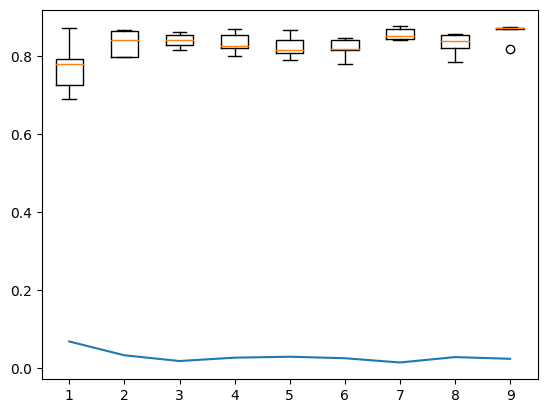

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"(150, 150)HoleMakerRandom",0.771931,0.069068
"(150, 150)HoleMakerBounded",0.833246,0.033719
"(150, 150)HoleMakerAttention",0.839168,0.019035
"(250, 250)HoleMakerRandom",0.833315,0.027629
"(250, 250)HoleMakerBounded",0.824224,0.030010
"(250, 250)HoleMakerAttention",0.820149,0.026173
"(350, 350)HoleMakerRandom",0.855982,0.015308
"(350, 350)HoleMakerBounded",0.830083,0.029112
"(350, 350)HoleMakerAttention",0.861155,0.024700


We save the results in order to plot them together.

In [ ]:
folds = [["TM" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("TransparenceMix")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

[0 1 2 3 4]


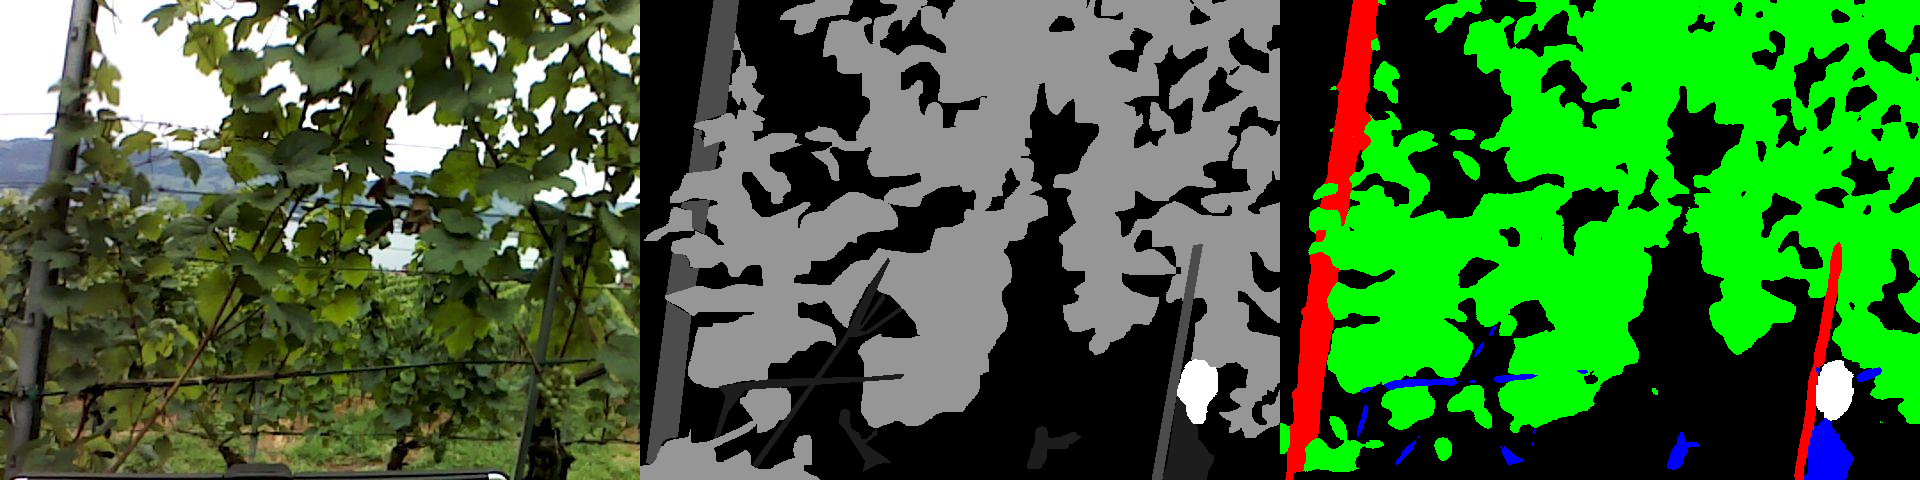

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

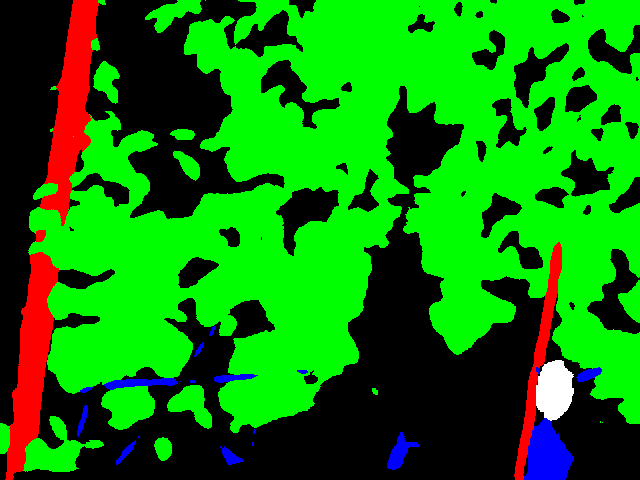

In [ ]:
mask